In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trainDatasetPath = '/content/drive/My Drive/data/train/'
testDatasetPath = '/content/drive/My Drive/data/test/'
test_noiseDataSetPath = '/content/drive/My Drive/data/test_noise/'
mtec_testDataSetPath = '/content/drive/My Drive/data/mtec_test/'
csvPath = '/content/drive/My Drive/data/ImageName_with_Class.csv'
train_csvPath = '/content/drive/My Drive/data/TrainingDataSplit.csv'
val_csvPath = '/content/drive/My Drive/data/ValidationDataSplit.csv'

In [3]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import numpy as np
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [4]:
#Input Image
imageHeight = 256
imageWidth = 256

modelImgSize = 224

numOutputClasses = 4

#Hyperparameters
batchSize = 16
learningRate = 0.001
epochs = 10



#GPU Info
print('Numbers of GPUs: ', torch.cuda.device_count())
print('Type of GPUs: ', torch.cuda.get_device_name(device=None))

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Numbers of GPUs:  1
Type of GPUs:  Tesla K80


In [ ]:
CompleteDataset = pd.read_csv(csvPath)
#print(CompleteDataset)

imageName = CompleteDataset['Image Name']
imageClass = CompleteDataset['Image Class']
#print(imageName)
#print(imageClass)

Xarr = imageName.to_numpy()
Yarr = imageClass.to_numpy()

X_Train, X_Val, Y_Train, Y_Val = train_test_split(Xarr, Yarr, test_size=0.2, shuffle=True, random_state=4)

trainingData = pd.DataFrame(list(zip(X_Train,Y_Train)),columns=['Image Name', 'Image Class'])

validationData = pd.DataFrame(list(zip(X_Val,Y_Val)),columns=['Image Name', 'Image Class'])

#print(trainingData)
#print(validationData)



In [ ]:
# Save Split Training and Validation Dataset to CSV files

trainingData.to_csv('TrainingDataSplit.csv',index=False)
!cp TrainingDataSplit.csv "drive/My Drive/data/"

validationData.to_csv('ValidationDataSplit.csv',index=False)
!cp ValidationDataSplit.csv "drive/My Drive/data/"

In [5]:
class CreateDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
train_transforms = transforms.Compose ([transforms.ToPILImage(),
                                        transforms.Resize((imageHeight,imageWidth)),
                                        transforms.CenterCrop(modelImgSize),
                                        transforms.RandomApply([transforms.RandomRotation(90)], p =0.4),
                                      transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

test_transforms =  transforms.Compose ([transforms.ToPILImage(),
                                        transforms.Resize((imageHeight,imageWidth)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

val_transforms = test_transforms

In [7]:
trainDataset = CreateDataset(csv_file = train_csvPath, img_dir = trainDatasetPath, transform = train_transforms)
trainDataloader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size = batchSize, shuffle = True, pin_memory=True)

totalItems = len(trainDataloader)
totalImages = totalItems * batchSize
print("Train DataLoader Items : " + str(totalItems))
print("No. of Training Images (Approx) : " + str(totalImages))

#Expected value of totalItems = Total No. of images in Dataset / batchSize

Train DataLoader Items : 847
No. of Training Images (Approx) : 13552


In [8]:
valDatasetPath = trainDatasetPath

valDataset = CreateDataset(csv_file = val_csvPath, img_dir = valDatasetPath, transform = val_transforms)
valDataloader = torch.utils.data.DataLoader(dataset = valDataset, batch_size = batchSize, shuffle = True, pin_memory=True)

totalItems = len(valDataloader)
totalImages = totalItems * batchSize
print("Validation DataLoader Items : " + str(totalItems))
print("No. of Validation Images (Approx)  : " + str(totalImages))


Validation DataLoader Items : 212
No. of Validation Images (Approx)  : 3392


Sample of Training Images


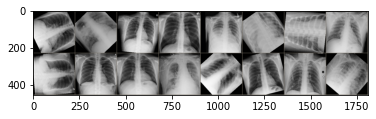

Sample of Validation Images


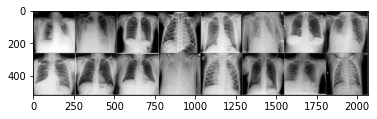

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data and make a grid
dataIter = iter(trainDataloader)
trainInputs, classes = dataIter.next()
trainingGrid = torchvision.utils.make_grid(trainInputs)
print("Sample of Training Images")
imshow(trainingGrid)


# Get a batch of training data and make a grid
valInputs, classes = next(iter(valDataloader))
validationGrid = torchvision.utils.make_grid(valInputs)
print("Sample of Validation Images")
imshow(validationGrid)

In [10]:
for images, labels in trainDataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    print(labels)
    break


Image batch dimensions: torch.Size([16, 3, 224, 224])
Image label dimensions: torch.Size([16])
tensor([3, 3, 0, 0, 0, 3, 3, 3, 1, 0, 3, 1, 1, 0, 3, 1])


In [11]:
model = torchvision.models.densenet121(pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [13]:
for param in model.parameters():
    param.requires_grad = False

lastLayers = nn.Sequential(#nn.Linear(2208, 1000), 
                           #nn.ReLU(),
                           #nn.Dropout(p=0.5),
                           nn.Linear(1024, 500), 
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(500, 100), 
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(100, numOutputClasses))

model.classifier = lastLayers

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [16]:
for epoch in range(epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainDataloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, batchSize)
        
        if i % 20 == 0:
          print('Epoch: {} | Loss: {} | Train Accuracy: {}'.format(epoch, train_running_loss / (i+1), train_acc/(i+1)))        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch+1, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.397204041481018 | Train Accuracy: 6.25
Epoch: 0 | Loss: 1.204139116264525 | Train Accuracy: 45.535714285714285
Epoch: 0 | Loss: 1.198854806946545 | Train Accuracy: 47.5609756097561
Epoch: 0 | Loss: 1.1840836395982837 | Train Accuracy: 48.5655737704918
Epoch: 0 | Loss: 1.1749380282413813 | Train Accuracy: 49.382716049382715
Epoch: 0 | Loss: 1.1473300752073232 | Train Accuracy: 50.92821782178218
Epoch: 0 | Loss: 1.12725605107536 | Train Accuracy: 52.27272727272727
Epoch: 0 | Loss: 1.1064370020906975 | Train Accuracy: 53.32446808510638
Epoch: 0 | Loss: 1.0843724241908292 | Train Accuracy: 54.54192546583851
Epoch: 0 | Loss: 1.0657086273583258 | Train Accuracy: 55.76657458563536
Epoch: 0 | Loss: 1.0498624441042468 | Train Accuracy: 56.52985074626866
Epoch: 0 | Loss: 1.0290191135794868 | Train Accuracy: 57.63574660633484
Epoch: 0 | Loss: 1.0163288158499848 | Train Accuracy: 58.01348547717842
Epoch: 0 | Loss: 1.0075860443699862 | Train Accuracy: 58.35727969348659
Epoch: 0 |

In [17]:
def save_checkpoint(state, filename="dense121frozen.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [19]:
 checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
 save_checkpoint(checkpoint)
 !cp dense121frozen.pth.tar "drive/My Drive/data/"

=> Saving checkpoint


In [ ]:
load_checkpoint(torch.load("/content/drive/My Drive/data/my_checkpoint.pth.tar"), model, optimizer)

In [20]:
test_acc = 0.0
for i, (images, labels) in enumerate(valDataloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, batchSize)
        
print('Validation Accuracy: %.2f'%( test_acc/i))

Validation Accuracy: 83.00
